Please note that this tutorial assumes you are already familiar
with technical details of kESI implementation.  If you are not,
consider running its expanded version
`tutorial_slice_basics_explained.ipynb` instead.

# Model

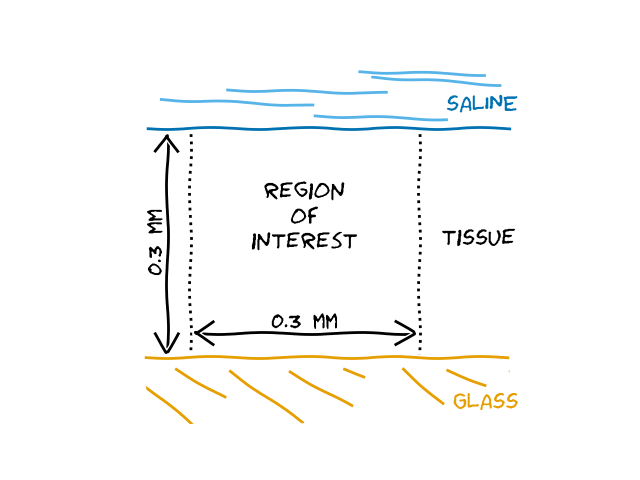

| Volume | Conductivity |
|:-------|:-------------|
| Saline | 1.5 S / m    |
| Tissue | 0.3 S / m    |
| Glass  | 0   S / m    |

# Requirements

## Memory

The code of the notebook requires at least 5.8 GB (5.4 GiB) of free memory.


## Environment

1. Anaconda Python distribution (tested with `Miniconda3-py39_4.12.0-Linux-x86_64.sh`, _conda v. 4.12.0_).
2. Jupyter server (see `extras/jupyter_server.sh` for details).
3. Anaconda environments (run `setup_conda_envs.sh`).
4. gmsh (not necessary if you already have meshes in either MSH or XDMF format).


## Setup

### Mesh

You need to have a mesh in XDMF format.  Try:

    cd extras
    conda activate kesi3.7
    snakemake data/generated/meshes/circular_slice/fine.xdmf -j 1

It may take a while<!-- (1-3 min)-->.  At least 233 MB (222 MiB) of free memory is necessary.

### Model properties

We are going to use the properties from the
`data/bundled/model_properties/single_sphere__Naess_Chintaluri_2017.ini` file.

### Electrodes

Lets define positions of three point electrodes:

    NAME,X,Y,Z
    first,0,0,0.5e-4
    second,0.5e-4,0,1.5e-4
    third,0.5e-4,-0.5e-4,2.5e-4

Write the positions as `data/generated/tutorial/slice/tutorial_electrodes.csv`.

# Preprocessing

## Calculation of the leadfield correction

For every electrode we use Finite Element Method (FEM) to calculate the leadfield correction:

    cd extras
    mkdir -p data/generated/tutorial/slice/fenics_leadfield_corrections
    python solve_slice_on_plate.py \
      --mesh data/generated/meshes/circular_slice/fine.xdmf \
      --degree 3 \
      --config data/bundled/model_properties/circular_slice__Ness_2015.ini \
      --electrodes data/generated/tutorial/slice/tutorial_electrodes.csv \
      --name first \
      --output data/generated/tutorial/slice/fenics_leadfield_corrections/first.ini
    python solve_slice_on_plate.py \
      --mesh data/generated/meshes/circular_slice/fine.xdmf \
      --degree 3 \
      --config data/bundled/model_properties/circular_slice__Ness_2015.ini \
      --electrodes data/generated/tutorial/slice/tutorial_electrodes.csv \
      --name second \
      --output data/generated/tutorial/slice/fenics_leadfield_corrections/second.ini
    python solve_slice_on_plate.py \
      --mesh data/generated/meshes/circular_slice/fine.xdmf \
      --degree 3 \
      --config data/bundled/model_properties/circular_slice__Ness_2015.ini \
      --electrodes data/generated/tutorial/slice/tutorial_electrodes.csv \
      --name third \
      --output data/generated/tutorial/slice/fenics_leadfield_corrections/third.ini

<!-- For fine:-->It may take a while<!-- (3 x 3.5 min)-->.  At least 2.89 GB (2.76 GiB) of free memory is required.

> Note, that for slice geometry a dedicated tool
> `solve_slice_on_plate.py` is used.

# TODO BELOW

## Sampling of the leadfield correction

We sample the correction on NxNxN grid, where `N = 2**K + 1` and `K = 7`:

    mkdir -p data/generated/tutorial/slice/sampled_leadfield_corrections
    python create_grid.py \
      --grid data/generated/tutorial/slice/leadfield_correction_grid.npz \
      --start -0.00015 -0.00015 0 \
      --end 0.00015 0.00015 0.0003 \
      -k 7
    python sample_volumetric_solution.py \
      --grid data/generated/tutorial/slice/leadfield_correction_grid.npz \
      --config data/generated/tutorial/slice/fenics_leadfield_corrections/first.ini \
      --output data/generated/tutorial/slice/sampled_leadfield_corrections/first.npz
    python sample_volumetric_solution.py \
      --grid data/generated/tutorial/slice/leadfield_correction_grid.npz \
      --config data/generated/tutorial/slice/fenics_leadfield_corrections/second.ini \
      --output data/generated/tutorial/slice/sampled_leadfield_corrections/second.npz
    python sample_volumetric_solution.py \
      --grid data/generated/tutorial/slice/leadfield_correction_grid.npz \
      --config data/generated/tutorial/slice/fenics_leadfield_corrections/third.ini \
      --output data/generated/tutorial/slice/sampled_leadfield_corrections/third.npz

It may a while<!-- (3 x 2 min)-->.  At least 1.25 GB (1.19 GiB) of free memory is necessary.


> Note, that for spherical geometries a dedicated tool
> `sample_volumetric_solution.py` is used.

# Kernel construction tools

## Electrode object

In [ ]:
from kesi.kernel.electrode import LinearlyInterpolatedLeadfieldCorrection as Electrode

# # The interpolation can be speeded up at the cost of precision by changing
# # the class to `NearestNeighbourInterpolatedLeadfieldCorrection`:
# from kesi.kernel.electrode import NearestNeighbourInterpolatedLeadfieldCorrection as Electrode

In [ ]:
electrodes = [Electrode(f"data/generated/tutorial/slice/sampled_leadfield_corrections/{name}.npz")
              for name in ['first', 'second', 'third']]

## Model source

We want to use CSD basis functions 36μm wide ($R = 18\mu{}m$).

In [ ]:
from kesi.common import SphericalSplineSourceKCSD


def get_model_source(radius):
    spline_nodes = [radius / 3, radius]
    spline_polynomial_coefficients = [[1],
                                      [0,
                                       6.75 / radius,
                                       -13.5 / radius ** 2,
                                       6.75 / radius ** 3]]
    return SphericalSplineSourceKCSD(0, 0, 0,
                                     spline_nodes,
                                     spline_polynomial_coefficients)

In [ ]:
SRC_R = 18e-6

model_src = get_model_source(SRC_R)

## Convolver object

In [ ]:
import numpy as np

from kesi.kernel.constructor import Convolver


ROMBERG_K = 5
Z_MIN = 0
Z_MAX = 3e-4
XY_AMP = 1.5e-4

_h_min = SRC_R * 2**(1 - ROMBERG_K)
_n_xy = int(np.floor(2 * XY_AMP / _h_min)) + 1
_n_z = int(np.floor((Z_MAX - Z_MIN) / _h_min)) + 1

_X = _Y = np.linspace(-XY_AMP, XY_AMP, _n_xy)
_Z = np.linspace(Z_MIN, Z_MAX, _n_z)

_csd_grid = _pot_grid = [_X, _Y, _Z]

convolver = Convolver(_pot_grid, _csd_grid)

for _c, _h in zip("XYZ", convolver.steps("POT")):
    assert _h >= _h_min, f"{_c}:\t{_h} < {_h_min}"
    if _h >= 2 * _h_min:
        print(f"You can reduce number of nodes of quadrature for {_c} dimension")

## Convolver interface

We include only CSD bases which supports fit in the _POT_ grid.

In [ ]:
from scipy.integrate import romb

from kesi.kernel.constructor import ConvolverInterfaceIndexed


ROMBERG_N = 2**ROMBERG_K + 1
ROMBERG_WEIGHTS = romb(np.identity(ROMBERG_N),
                       dx=2**-ROMBERG_K)

SRC_MASK = ((convolver.SRC_Z > Z_MIN + SRC_R)
            & (convolver.SRC_Z < Z_MAX - SRC_R)
            & (abs(convolver.SRC_X) < XY_AMP - SRC_R)
            & (abs(convolver.SRC_Y) < XY_AMP - SRC_R))

In [ ]:
print(SRC_MASK.sum())

In [ ]:
convolver_interface = ConvolverInterfaceIndexed(convolver,
                                                model_src.csd,
                                                ROMBERG_WEIGHTS,
                                                SRC_MASK)

## Potential Basis Functions object

### Potential Basis Functions: analytical solution of the forward problem (kCSD)

In [ ]:
import kesi.kernel.potential_basis_functions as pbf

In [ ]:
pbf_kcsd = pbf.Analytical(convolver_interface,
                          potential=model_src.potential)

### Potential Basis Functions: numerically corrected analytical solution of the forward problem (kESI)

In [ ]:
pbf_kesi = pbf.AnalyticalCorrectedNumerically(convolver_interface,
                                              potential=model_src.potential)

## (Cross)kernel constructors

In [ ]:
from kesi.kernel.constructor import KernelConstructor, CrossKernelConstructor

In [ ]:
kernel_constructor = KernelConstructor()

In [ ]:
CSD_MASK = np.ones(convolver.shape('CSD'),
                   dtype=bool)

In [ ]:
kernel_constructor.crosskernel = CrossKernelConstructor(convolver_interface,
                                                        CSD_MASK)

In [ ]:
def to_3D(CSD):
    return CSD.reshape(convolver.shape('CSD'))

# kCSD reconstructor

## Construction of kernels

In [ ]:
%%time
B_KCSD = kernel_constructor.potential_basis_functions_at_electrodes(electrodes,
                                                                    pbf_kcsd)

In [ ]:
KERNEL_KCSD = kernel_constructor.kernel(B_KCSD)

In [ ]:
%%time
CROSSKERNEL_KCSD = kernel_constructor.crosskernel(B_KCSD)

In [ ]:
del B_KCSD  # the array is large and no longer needed

## Reconstructor object

In [ ]:
from kesi import Reconstructor

In [ ]:
reconstructor_kcsd = Reconstructor(KERNEL_KCSD,
                                   CROSSKERNEL_KCSD)

# TODO BELOW

# Visualisation

In [ ]:
import matplotlib.pyplot as plt

from local import cbf
from local.tutorial.view import Slice as CoordinatePlanesVisualisation

In [ ]:
csd_plotter = CoordinatePlanesVisualisation(convolver.CSD_GRID,
                                            [5e-5, 0, 1.5e-4],
                                            unit_factor=1e-12,
                                            unit='$\\frac{\\mu{}A}{mm^3}$',
                                            length_factor=1e6,
                                            length_unit='$\\mu{}m$')

# Ground truth CSD and its potential at the electrodes

## GT CSD

In [ ]:
%%time
EIGENVALUES_KCSD, EIGENVECTORS_KCSD = np.linalg.eigh(KERNEL_KCSD)
EIGENVALUES_KCSD, EIGENVECTORS_KCSD = EIGENVALUES_KCSD[::-1], EIGENVECTORS_KCSD[:, ::-1]

GT_CSD = to_3D(reconstructor_kcsd(EIGENVECTORS_KCSD[:, 0] * 2e5))

In [ ]:
csd_plotter.plot_volume(GT_CSD, 'GT CSD')

## FEM forward modelling

In [ ]:
import scipy.interpolate as si

from local.tutorial import SliceForwardModel as ForwardModel

In [ ]:
%%time
fem = ForwardModel("data/generated/meshes/circular_slice/fine.xdmf",
                   3,
                   "data/bundled/model_properties/circular_slice__Ness_2015.ini")

In [ ]:
%%time
_csd_grid = [_x.flatten() for _x in convolver.CSD_GRID]
_csd = si.RegularGridInterpolator(_csd_grid,
                                  GT_CSD,
                                  bounds_error=False,
                                  fill_value=0)
potential = fem(_csd)

del _csd  # the object is large and no longer needed

It may take more than 2 minutes.

We visualise the potential.

In [ ]:
potential_plotter = CoordinatePlanesVisualisation(convolver.CSD_GRID,
                                                  [5e-5, 0, 1.5e-4],
                                                  cmap=cbf.PRGn,
                                                  unit='$\\mu{}V$',
                                                  unit_factor=1e-3,
                                                  length_unit='$\\mu{}m$',
                                                  length_factor=1e6)

In [ ]:
%%time
_potential = np.vectorize(potential) 
V_PLANES = [_potential(np.reshape(_X, (-1, 1, 1)),
                       np.reshape(_Y, (1, -1, 1)),
                       np.reshape(_Z, (1, 1, -1)))
            for _X, _Y, _Z in potential_plotter.PLANES_XYZ
            ]
del _potential

In [ ]:
potential_plotter.plot_planes(V_PLANES, 'POTENTIAL')

We probe the potential at electrodes.

In [ ]:
GT_V = np.array([potential(_e.x, _e.y, _e.z) for _e in electrodes])

In [ ]:
del potential, fem  # these objects are large and no longer needed

# Reconstruction

## kCSD

In [ ]:
CSD_KCSD = to_3D(reconstructor_kcsd(GT_V))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KCSD,
                            'kCSD')

The reconstruction does not match the ground truth.

In [ ]:
del CSD_KCSD  # the array is large and no longer needed

In [ ]:
del reconstructor_kcsd, CROSSKERNEL_KCSD  # these objects are large and no longer needed

## kESI

In [ ]:
%%time
B_KESI = kernel_constructor.potential_basis_functions_at_electrodes(electrodes,
                                                                    pbf_kesi)

It may take more than 2 minutes.

In [ ]:
KERNEL_KESI = kernel_constructor.kernel(B_KESI)

In [ ]:
%%time
CROSSKERNEL_KESI = kernel_constructor.crosskernel(B_KESI)

In [ ]:
del B_KESI  # the array is large and no longer needed

In [ ]:
reconstructor_kesi = Reconstructor(KERNEL_KESI,
                                   CROSSKERNEL_KESI)

In [ ]:
CSD_KESI = to_3D(reconstructor_kesi(GT_V))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI,
                            'kESI')

The reconstruction is pretty close to the ground truth.

In [ ]:
del CSD_KESI  # the array is large and no longer needed

## Noise

As no real-world measurement is perfect, we introduce 30% noise to see, how kESI may deal with it (the noise needs to be quite strong, as difference between the largest ans the smallest eigenvalue is not very substantial):

In [ ]:
np.random.seed(42)
V_WITH_NOISE = np.random.normal(loc=GT_V,
                                scale=0.30*np.sqrt(np.square(GT_V).mean()))

In [ ]:
CSD_KESI_WITH_NOISE = to_3D(reconstructor_kesi(V_WITH_NOISE))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI_WITH_NOISE,
                            'kESI (noise)')

In [ ]:
del CSD_KESI_WITH_NOISE  # the array is large and no longer needed

## Regularization

In [ ]:
EIGENVALUES_KESI = np.linalg.eigvalsh(KERNEL_KESI)[::-1]

In [ ]:
plt.plot(EIGENVALUES_KESI,
         marker='o')

plt.yscale('log')

In [ ]:
REGULARIZATION_PARAMETERS = np.logspace(11, 17, 6 * 10 + 1)

### Leave-one-out cross-validation

In [ ]:
from kesi.common import cv

In [ ]:
%%time
CV_ERRORS = cv(reconstructor_kesi, V_WITH_NOISE, REGULARIZATION_PARAMETERS)

In [ ]:
regularization_parameter = REGULARIZATION_PARAMETERS[np.argmin(CV_ERRORS)]

In [ ]:
plt.plot(REGULARIZATION_PARAMETERS,
         CV_ERRORS,
         color=cbf.BLUE)
plt.plot(regularization_parameter,
         min(CV_ERRORS),
         marker="o",
         color=cbf.BLUE)
plt.axvspan(EIGENVALUES_KESI.min(),
            EIGENVALUES_KESI.max(),
            ls=":",
            color=cbf.GREEN,
            hatch=".....",
            fill=False)
plt.xscale('log')
plt.xlabel('regularization parameter')
plt.yscale('log')
plt.ylabel('L2 norm of cross-validation error')

As the smallest value of `REGULARIZATION_PARAMETERS` has been chosen (which is 2 orders of magnitude smaller than any of the kernel eigenvalues), it seems that cross-validation is against regularization.

### L-curve

In [ ]:
model_norm = []
error = []
for _regularization_parameter in REGULARIZATION_PARAMETERS:
    _beta = np.linalg.solve(KERNEL_KESI + _regularization_parameter * np.identity(len(electrodes)),
                            V_WITH_NOISE)
    _V = np.matmul(KERNEL_KESI, _beta)
    error.append(np.sqrt(np.square(V_WITH_NOISE - _V).mean()))
    model_norm.append(np.dot(_beta, _V))

In [ ]:
_idx_low, _idx_high = np.searchsorted(REGULARIZATION_PARAMETERS,
                                      [EIGENVALUES_KESI.min(),
                                       EIGENVALUES_KESI.max()])
_bottom = model_norm[_idx_high]
_top = model_norm[_idx_low]
_left = error[_idx_low]
_right = error[_idx_high]

fig, ax = plt.subplots()
ax.plot(error, model_norm,
        marker='.',
        color=cbf.BLUE)
ax.add_patch(plt.Rectangle((_left, _bottom),
                           _right - _left,
                           _top - _bottom,
                           ls=':',
                           edgecolor=cbf.BLACK,
                           facecolor='none'))

ax.set_yscale('log')
ax.set_ylabel('norm of the model')
ax.set_xscale('log')
ax.set_xlabel('L2 norm of the prediction error')
ax.set_title('L-curve')


fig, ax = plt.subplots()
ax.plot(error, model_norm,
        marker='.',
        color=cbf.BLUE)

ax.set_yscale('log')
ax.set_ylabel('norm of the model')
ax.set_xscale('log')
ax.set_xlabel('L2 norm of the prediction error')
ax.set_xlim(_left, _right)
ax.set_ylim(_bottom, _top)
_ = ax.set_title('L-curve cropped to the range of eigenvalues')

### Expert knowledge

As neither cross-validation nor the L-curve method allowed to select a regularization, the expert knowledge has been used to choose `3_000_000_000_000` (`3e12`) as a value expected to damp all eigensources but the original.

In [ ]:
CSD_KESI_EXPERT_KNOWLEDGE = to_3D(reconstructor_kesi(V_WITH_NOISE, 3e12))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI_EXPERT_KNOWLEDGE,
                            'kESI (regularized)')

In [ ]:
del CSD_KESI_EXPERT_KNOWLEDGE  # the array is large and no longer needed